# Analyse noise in photos

Analyse images of black paper sheet in WiggleBin to find the right threshold to filter out noise in images

In [131]:
import matplotlib.pyplot as plt
from skimage import measure
import os
import matplotlib.pyplot as plt
from datetime import datetime
import glob

In [132]:
# Specify the directory where the images are located
folder = "2024-06-19-02"
image_dir = f"data/{folder}"

# Get a list of all image files in the directory and its subdirectories
image_files = glob.glob(os.path.join(image_dir, '**/*.jpg'), recursive=True) + glob.glob(os.path.join(image_dir, '**/*.png'), recursive=True)

# Sort the image files
image_files = sorted(image_files)

# Print the list of image files
print(image_files)

['data/2024-06-19-02/2024-06-19-02-00.jpg', 'data/2024-06-19-02/2024-06-19-02-01.jpg', 'data/2024-06-19-02/2024-06-19-02-02.jpg', 'data/2024-06-19-02/2024-06-19-02-03.jpg', 'data/2024-06-19-02/2024-06-19-02-04.jpg', 'data/2024-06-19-02/2024-06-19-02-05.jpg', 'data/2024-06-19-02/2024-06-19-02-06.jpg', 'data/2024-06-19-02/2024-06-19-02-07.jpg', 'data/2024-06-19-02/2024-06-19-02-08.jpg', 'data/2024-06-19-02/2024-06-19-02-09.jpg', 'data/2024-06-19-02/2024-06-19-02-10.jpg', 'data/2024-06-19-02/2024-06-19-02-11.jpg', 'data/2024-06-19-02/2024-06-19-02-12.jpg', 'data/2024-06-19-02/2024-06-19-02-13.jpg', 'data/2024-06-19-02/2024-06-19-02-14.jpg', 'data/2024-06-19-02/2024-06-19-02-15.jpg', 'data/2024-06-19-02/2024-06-19-02-16.jpg', 'data/2024-06-19-02/2024-06-19-02-17.jpg', 'data/2024-06-19-02/2024-06-19-02-18.jpg', 'data/2024-06-19-02/2024-06-19-02-19.jpg', 'data/2024-06-19-02/2024-06-19-02-20.jpg', 'data/2024-06-19-02/2024-06-19-02-21.jpg', 'data/2024-06-19-02/2024-06-19-02-22.jpg', 'data/2024

In [133]:
import cv2
import numpy as np
import pandas as pd

def calculate_pixel_change(image1, image2):
    # Calculate the pixel value change
    pixel_change = np.abs(image1.astype(int) - image2.astype(int)).max()

    return pixel_change

# Initialize the previous image
prev_image = None

# Initialize a list to store the data
data = []

# Loop over the image files
for image_file in image_files:
    # Load the current image
    curr_image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

    # If there is a previous image, calculate the pixel change
    if prev_image is not None:
        pixel_change = calculate_pixel_change(prev_image, curr_image)
        data.append([image_file, pixel_change])

    # Update the previous image
    prev_image = curr_image

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=['image_name', 'highest_change'])

# Sort the DataFrame by the 'highest_change' column in descending order
df = df.sort_values(by='highest_change', ascending=False)

# Print the DataFrame
df.head()

,image_name,highest_change
58,data/2024-06-19-02/2024-06-19-02-59.jpg,13
30,data/2024-06-19-02/2024-06-19-02-31.jpg,13
25,data/2024-06-19-02/2024-06-19-02-26.jpg,12
29,data/2024-06-19-02/2024-06-19-02-30.jpg,12
12,data/2024-06-19-02/2024-06-19-02-13.jpg,11


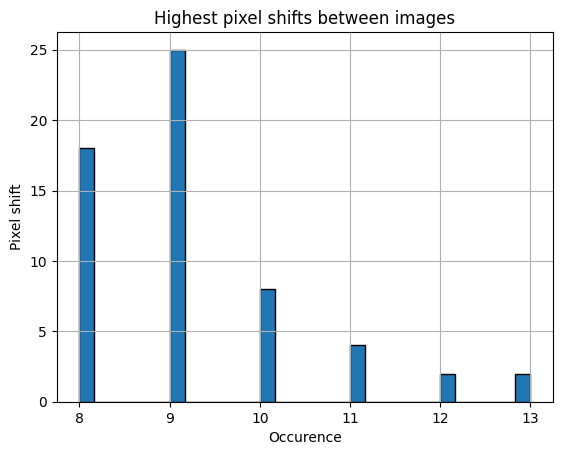

In [142]:
# Assuming mean_gray_values is a list or a pandas Series
plt.hist(df['highest_change'], bins=30, edgecolor='black')
plt.xlabel('Occurence')
plt.ylabel('Pixel shift')
plt.title('Highest pixel shifts between images')
plt.grid(True)
plt.show()

In [135]:
image = cv2.imread('data/2024-06-19-02/2024-06-19-02-59.jpg', cv2.IMREAD_GRAYSCALE)
compared_to_image = cv2.imread('data/2024-06-19-02/2024-06-19-02-58.jpg', cv2.IMREAD_GRAYSCALE)

In [136]:
def calculate_diff_and_find_contours(image, compared_to_image, threshold):
    # Calculate the difference
    diff = image.astype(int) - compared_to_image.astype(int)

    # Find contours for lighter and darker areas
    contours_lighter = measure.find_contours(diff, threshold)
    contours_darker = measure.find_contours(-diff, threshold)

    lighter_pixels = np.sum(diff > threshold)
    darker_pixels = np.sum(diff < -threshold)

    return contours_lighter, contours_darker, lighter_pixels, darker_pixels

def get_contours_by_size(contours, image, small_contour_threshold):
    small_contour_list = []
    large_contour_list = []
    
    for contour in contours:
        # Create a binary image for the contour
        contour_image = np.zeros_like(image)
        contour_image[np.round(contour[:, 0]).astype(int), np.round(contour[:, 1]).astype(int)] = 1

        # Calculate the area of the contour
        area = np.sum(contour_image)
        
        if area < small_contour_threshold:
            small_contour_list.append(contour)
        else:
            large_contour_list.append(contour)
    
    return small_contour_list, large_contour_list

In [137]:
def get_contour_info_and_contours(image, compared_to_image, threshold, small_contour_threshold):
    # Calculate difference and find contours
    contours_lighter, contours_darker, lighter_pixels, darker_pixels = calculate_diff_and_find_contours(image, compared_to_image, threshold)

    # Get contours by size
    small_contours_lighter, large_contours_lighter = get_contours_by_size(contours_lighter, image, small_contour_threshold)
    small_contours_darker, large_contours_darker = get_contours_by_size(contours_darker, image, small_contour_threshold)

    # Calculate total areas
    total_area_lighter_small = sum([np.sum(contour) for contour in small_contours_lighter])
    total_area_lighter_large = sum([np.sum(contour) for contour in large_contours_lighter])
    total_area_darker_small = sum([np.sum(contour) for contour in small_contours_darker])
    total_area_darker_large = sum([np.sum(contour) for contour in large_contours_darker])

    # Create a dictionary to store the results
    contour_info = {
        'lighter': {
            'count_pixels': lighter_pixels,
            'small': {
                'count': len(small_contours_lighter),
                'total_area': total_area_lighter_small
            },
            'large': {
                'count': len(large_contours_lighter),
                'total_area': total_area_lighter_large
            }
        },
        'darker': {
            'count_pixels': darker_pixels,
            'small': {
                'count': len(small_contours_darker),
                'total_area': total_area_darker_small
            },
            'large': {
                'count': len(large_contours_darker),
                'total_area': total_area_darker_large
            }
        }
    }

    # Return both the contour info and the contours
    return contour_info, small_contours_lighter, large_contours_lighter, small_contours_darker, large_contours_darker

In [138]:
def plot_contours(small_contours_lighter, large_contours_lighter, small_contours_darker, large_contours_darker, image):
    # Display the original image and plot all contours found
    fig, ax = plt.subplots()
    ax.imshow(image, cmap=plt.cm.gray)

    for contour in small_contours_lighter:
        ax.plot(contour[:, 1], contour[:, 0], color='blue', linewidth=1, alpha=0.8)

    for contour in large_contours_lighter:
        ax.plot(contour[:, 1], contour[:, 0], color='green', linewidth=1, alpha=0.8)

    for contour in small_contours_darker:
        ax.plot(contour[:, 1], contour[:, 0], color='orange', linewidth=1, alpha=0.8)

    for contour in large_contours_darker:
        ax.plot(contour[:, 1], contour[:, 0], color='red', linewidth=1, alpha=0.8)

    plt.show()

{'lighter': {'count_pixels': 104302, 'small': {'count': 2917, 'total_area': 40868338.798412725}, 'large': {'count': 480, 'total_area': 32759940.259379502}}, 'darker': {'count_pixels': 103426, 'small': {'count': 2931, 'total_area': 41174128.41984128}, 'large': {'count': 496, 'total_area': 31884244.673665226}}}


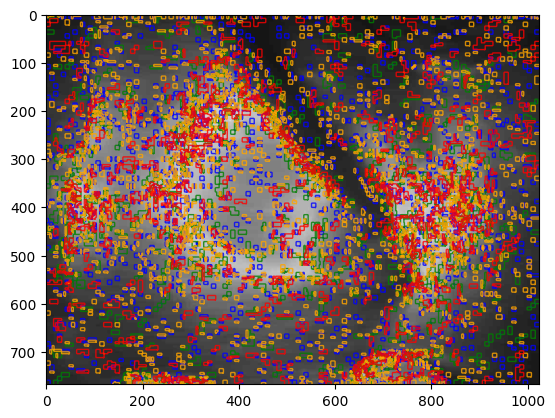

In [139]:
(contour_info, 
 small_contours_lighter, 
 large_contours_lighter, 
 small_contours_darker, 
 large_contours_darker
) = get_contour_info_and_contours(image, compared_to_image, threshold=0, small_contour_threshold=40)

print(contour_info)

plot_contours(small_contours_lighter, large_contours_lighter, small_contours_darker, large_contours_darker, image)

{'lighter': {'count_pixels': 5, 'small': {'count': 1, 'total_area': 4654.166666666667}, 'large': {'count': 0, 'total_area': 0}}, 'darker': {'count_pixels': 0, 'small': {'count': 0, 'total_area': 0}, 'large': {'count': 0, 'total_area': 0}}}


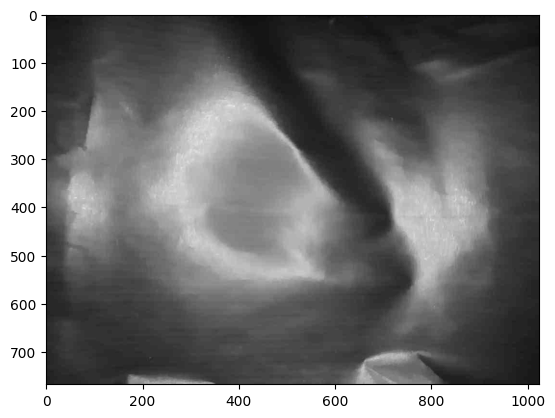

In [140]:
(contour_info, 
 small_contours_lighter, 
 large_contours_lighter, 
 small_contours_darker, 
 large_contours_darker
) = get_contour_info_and_contours(image, compared_to_image, threshold=10, small_contour_threshold=40)

print(contour_info)

plot_contours(small_contours_lighter, large_contours_lighter, small_contours_darker, large_contours_darker, image)